In [ ]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import implicit

import sys
sys.path.append('..')

from src.datasets import load_dataset
from src.utils import get_table_barplot
from src.evaluation.evaluation import downvote_seen_items, topn_recommendations, model_evaluate
from src.models import NGCF, ALS, eALS, iALS

### Load Data

In [2]:
data_path = '../data'

training_yelp, testset_yelp, holdout_yelp, training_matrix_yelp, data_description_yelp = load_dataset('yelp', data_path)
training_movielens, testset_movielens, holdout_movielens, training_matrix_movielens, data_description_movielens = load_dataset('movielens', data_path)

### Load Pretrained Models

In [3]:
import torch

models_movielens = [
    ('ALS', ALS.from_checkpoint('../weights/als_movielens.pkl')),
    ('eALS', eALS.from_checkpoint('../weights/eals_movielens.pkl')),
    ('iALS', iALS.from_checkpoint('../weights/ials_movielens.pkl')),
    ('NGCF', NGCF.from_checkpoint('../weights/ngcf_movielens.pth'))
]

if torch.cuda.is_available():
    models_movielens = [(name, model.cuda()) for name, model in models_movielens]

models_yelp = [
    ('ALS', ALS.from_checkpoint('../weights/als_yelp.pkl')),
    ('eALS', eALS.from_checkpoint('../weights/eals_yelp.pkl')),
    ('iALS', iALS.from_checkpoint('../weights/ials_yelp.pkl')),
    ('NGCF', NGCF.from_checkpoint('../weights/ngcf_yelp.pth'))
]

if torch.cuda.is_available():
    models_yelp = [(name, model.cuda()) for name, model in models_yelp]

### Score Models

In [4]:
topn = 10


def evaluate_model(model, holdout, testset, data_description, topn=10, verbose=False):
    scores = model.score_users(holdout.userid.values)
    downvote_seen_items(scores, testset, data_description)
    recs = topn_recommendations(scores, topn=topn)

    hr, mrr, ndcg, cov = model_evaluate(recs, holdout, data_description, topn=topn)

    if verbose:
        print(f'HR@{topn} = {hr:.4f}')
        print(f'MRR@{topn} = {mrr:.4f}')
        print(f'nDCG@{topn} = {ndcg:.4f}')
        print(f'COV@{topn} = {cov:.4f}')

    return hr, mrr, ndcg, cov


def score_models(models, holdout, testset, data_description):
    scores = dict()
    for name, model in models:
        scores[name] = evaluate_model(model, holdout, testset, data_description)

    scores = pd.DataFrame(scores, index=['HR', 'MRR', 'nDCG', 'COV']).T
    return scores

In [5]:
scores_movielens = score_models(models_movielens, holdout_movielens, testset_movielens, data_description_movielens)
scores_movielens.style.background_gradient()

,HR,MRR,nDCG,COV
ALS,0.102318,0.036046,0.051282,0.367171
eALS,0.099338,0.035760,0.050432,0.364201
iALS,0.101325,0.035419,0.050591,0.366091
NGCF,0.082450,0.026750,0.039567,0.674946


,HR,MRR,nDCG,COV
ALS,0.102318,0.036046,0.051282,0.367171
eALS,0.099338,0.035760,0.050432,0.364201
iALS,0.101325,0.035419,0.050591,0.366091
NGCF,0.082450,0.026750,0.039567,0.674946


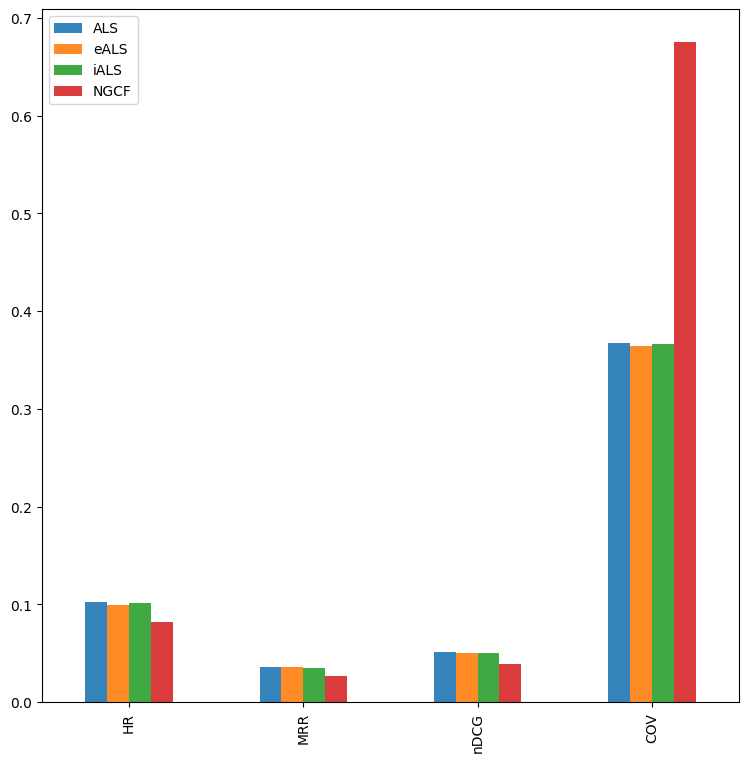

In [6]:
get_table_barplot(scores_movielens, stacked=False, figsize=(9, 9))

In [7]:
scores_yelp = score_models(models_yelp, holdout_yelp, testset_yelp, data_description_yelp)
scores_yelp.style.background_gradient()

,HR,MRR,nDCG,COV
ALS,0.041477,0.015488,0.021485,0.062410
eALS,0.041048,0.015388,0.021323,0.061712
iALS,0.040854,0.015152,0.021101,0.061906
NGCF,0.037154,0.013125,0.018649,0.143373


,HR,MRR,nDCG,COV
ALS,0.041477,0.015488,0.021485,0.062410
eALS,0.041048,0.015388,0.021323,0.061712
iALS,0.040854,0.015152,0.021101,0.061906
NGCF,0.037154,0.013125,0.018649,0.143373


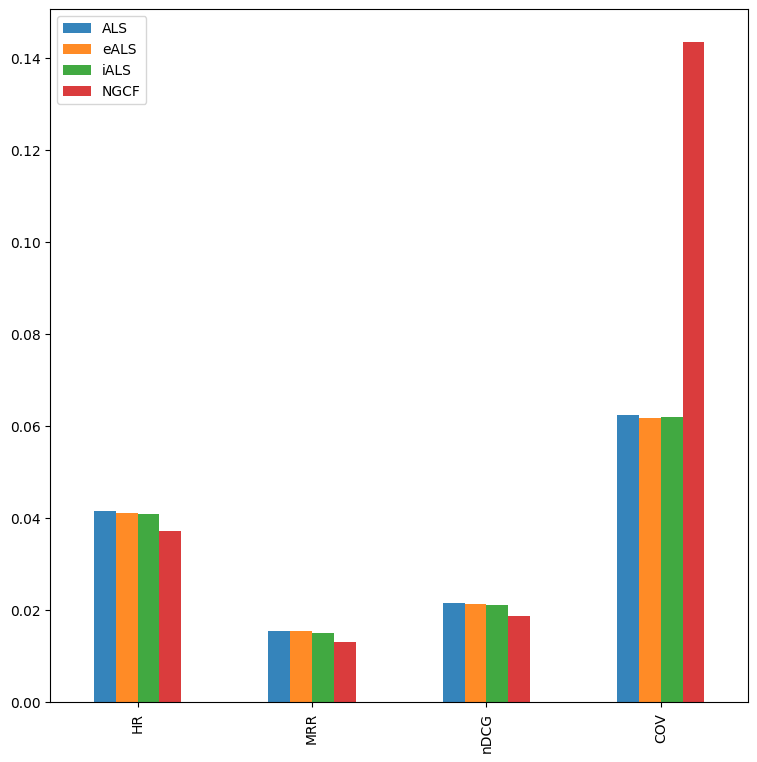

In [8]:
get_table_barplot(scores_yelp, stacked=False, figsize=(9, 9))

### Implicit Models

In [9]:
def evaluate_implicit_model(implicit_model, holdout, training_matrix, data_description, topn=10, verbose=False):
    model = implicit_model(iterations=100, regularization=0.1, use_gpu=True)
    model.fit(training_matrix)

    recs = model.recommend(np.arange(training_matrix.shape[0]), training_matrix, N=topn, filter_already_liked_items=True)[0]
    hr, mrr, ndcg, cov = model_evaluate(recs, holdout, data_description, topn=topn)

    if verbose:
        print(f'HR@{topn} = {hr:.4f}')
        print(f'MRR@{topn} = {mrr:.4f}')
        print(f'nDCG@{topn} = {ndcg:.4f}')
        print(f'COV@{topn} = {cov:.4f}')

    return hr, mrr, ndcg, cov


def score_implicit_models(implicit_models, holdout, training_matrix, data_description):
    scores = dict()
    for name, model in implicit_models:
        metrics = evaluate_implicit_model(model, holdout, training_matrix, data_description, topn=topn)
        scores[name] = metrics

    scores = pd.DataFrame(scores, index=['HR', 'MRR', 'nDCG', 'COV']).T
    return scores

In [10]:
implicit_models = [
    ('ALS-impl', implicit.als.AlternatingLeastSquares), 
    ('BPR-impl', implicit.bpr.BayesianPersonalizedRanking)
]

scores_implicit_movielens = score_implicit_models(implicit_models, holdout_movielens, training_matrix_movielens, data_description_movielens)
scores_implicit_movielens.style.background_gradient()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,HR,MRR,nDCG,COV
ALS-impl,0.097020,0.034297,0.048729,0.417387
BPR-impl,0.043543,0.016080,0.022444,0.356102


In [11]:
scores_implicit_yelp = score_implicit_models(implicit_models, holdout_yelp, training_matrix_yelp, data_description_yelp)
scores_implicit_yelp.style.background_gradient()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,HR,MRR,nDCG,COV
ALS-impl,0.051486,0.019328,0.026760,0.085620
BPR-impl,0.005764,0.002355,0.003147,0.021541


### Comparison with Implicit

In [12]:
print('Movielens:')
common_movielens = pd.concat([scores_movielens, scores_implicit_movielens])
common_movielens.style.background_gradient()

Movielens:


,HR,MRR,nDCG,COV
ALS,0.102318,0.036046,0.051282,0.367171
eALS,0.099338,0.035760,0.050432,0.364201
iALS,0.101325,0.035419,0.050591,0.366091
NGCF,0.082450,0.026750,0.039567,0.674946
ALS-impl,0.097020,0.034297,0.048729,0.417387
BPR-impl,0.043543,0.016080,0.022444,0.356102


,HR,MRR,nDCG,COV
ALS,0.102318,0.036046,0.051282,0.367171
eALS,0.099338,0.035760,0.050432,0.364201
iALS,0.101325,0.035419,0.050591,0.366091
NGCF,0.082450,0.026750,0.039567,0.674946
ALS-impl,0.097020,0.034297,0.048729,0.417387
BPR-impl,0.043543,0.016080,0.022444,0.356102


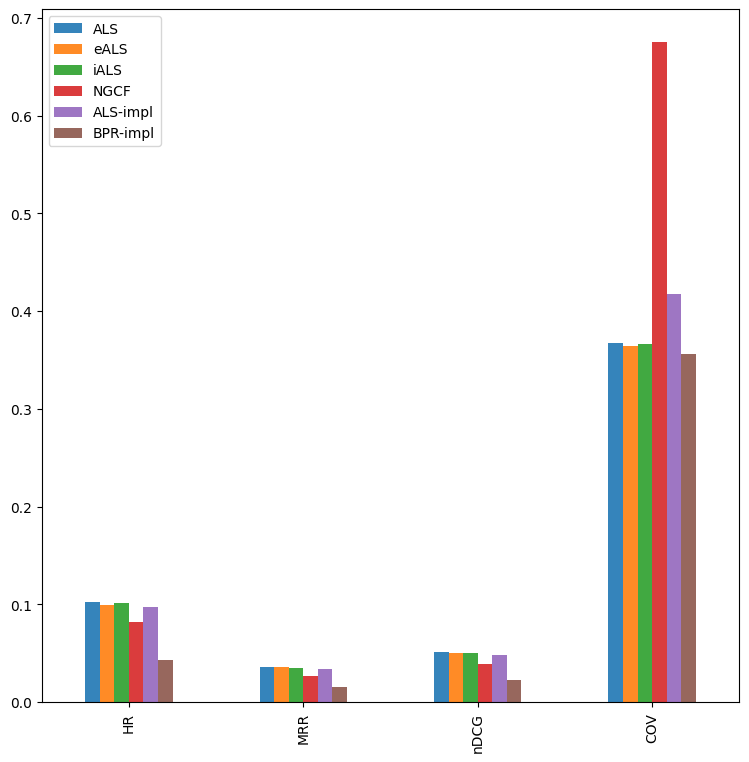

In [13]:
get_table_barplot(common_movielens, model_names=common_movielens.index, stacked=False, figsize=(9, 9))

In [14]:
print('Yelp:')
common_yelp = pd.concat([scores_yelp, scores_implicit_yelp])
common_yelp.style.background_gradient()

Yelp:


,HR,MRR,nDCG,COV
ALS,0.041477,0.015488,0.021485,0.062410
eALS,0.041048,0.015388,0.021323,0.061712
iALS,0.040854,0.015152,0.021101,0.061906
NGCF,0.037154,0.013125,0.018649,0.143373
ALS-impl,0.051486,0.019328,0.026760,0.085620
BPR-impl,0.005764,0.002355,0.003147,0.021541


,HR,MRR,nDCG,COV
ALS,0.041477,0.015488,0.021485,0.062410
eALS,0.041048,0.015388,0.021323,0.061712
iALS,0.040854,0.015152,0.021101,0.061906
NGCF,0.037154,0.013125,0.018649,0.143373
ALS-impl,0.051486,0.019328,0.026760,0.085620
BPR-impl,0.005764,0.002355,0.003147,0.021541


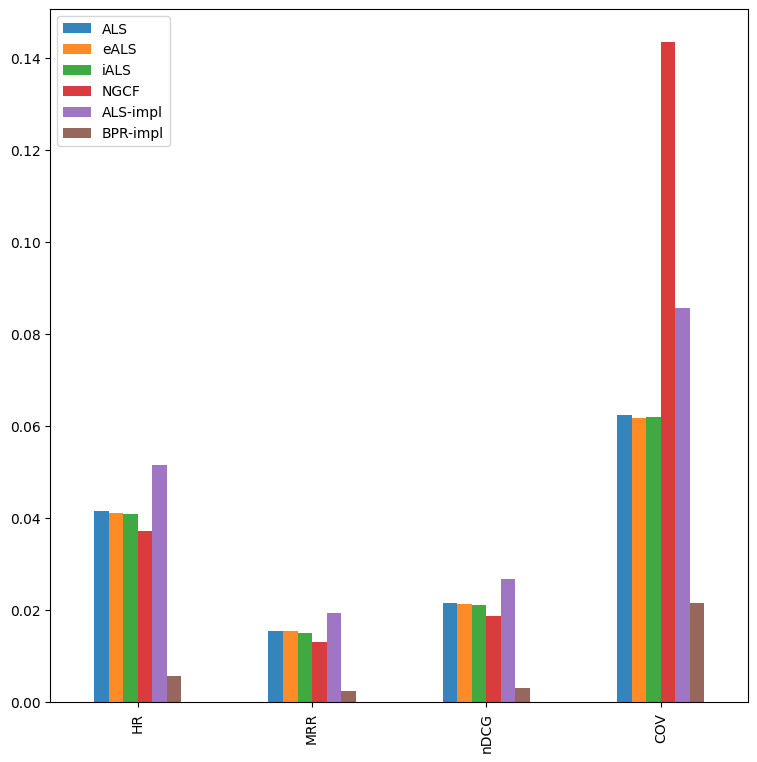

In [15]:
get_table_barplot(common_yelp, model_names=common_yelp.index, stacked=False, figsize=(9, 9))

### Training Time

In [16]:
def score_times(models, training_matrix):
    times = dict()
    for name, model in models:
        start = time.time()
        model.fit(training_matrix)
        elapsed = time.time() - start
        times[name] = elapsed

    return times

In [ ]:
factors = 100
device = 'cuda'

models = [
    ('ALS', ALS(factors=factors, device=device)),
    ('eALS', eALS(factors=factors, device=device)),
    ('iALS', iALS(factors=factors, device=device)),
    ('ALS-impl', implicit.als.AlternatingLeastSquares(factors=factors, iterations=100, use_gpu=True)),
    ('BPR-impl', implicit.bpr.BayesianPersonalizedRanking(factors=factors, iterations=100, use_gpu=True))
]

times_movielens = score_times(models, training_matrix_movielens)
times_movielens['NGCF'] = 2.19 # one epoch

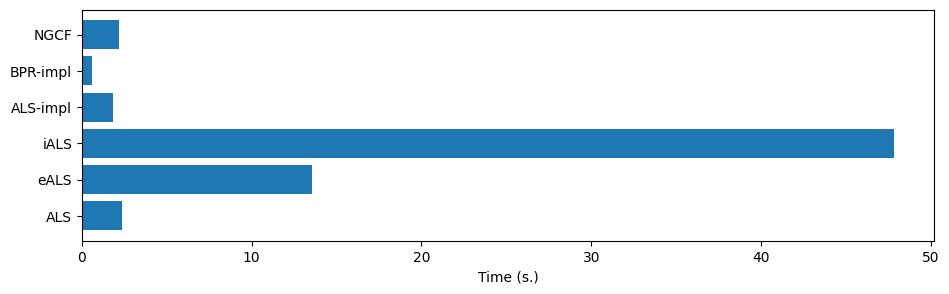

In [18]:
plt.figure(figsize=(11, 3))
plt.barh(list(times_movielens.keys()), list(times_movielens.values()))
plt.xlabel('Time (s.)')
plt.show()

In [ ]:
models = [
    ('ALS', ALS(factors=factors, device=device)),
    ('eALS', eALS(factors=factors, device=device)),
    ('iALS', iALS(factors=factors, device=device)),
    ('ALS-impl', implicit.als.AlternatingLeastSquares(factors=factors, iterations=100, use_gpu=True)),
    ('BPR-impl', implicit.bpr.BayesianPersonalizedRanking(factors=factors, iterations=100, use_gpu=True))
]

times_yelp = score_times(models, training_matrix_yelp)
times_yelp['NGCF'] = 44.7 # one epoch

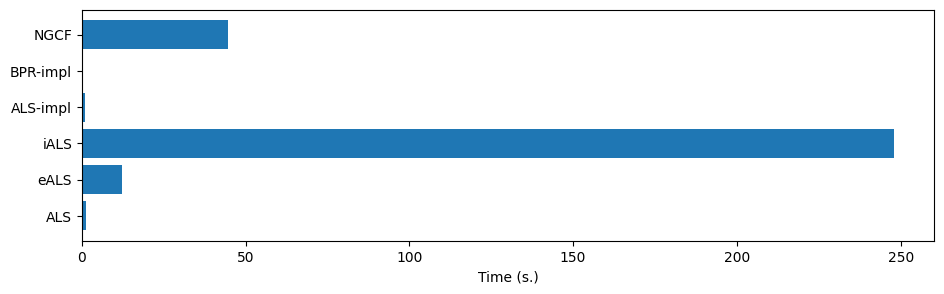

In [21]:
plt.figure(figsize=(11, 3))
plt.barh(list(times_yelp.keys()), list(times_yelp.values()))
plt.xlabel('Time (s.)')
plt.show()

### Theoretical Complexity

In [16]:
from IPython.display import clear_output
from scipy.sparse import csr_matrix


device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = [
    ('ALS', ALS),
    ('eALS', eALS),
    ('iALS', iALS)
]

R = np.random.randint(2, size=(5, 10))
R = csr_matrix(R)

factors = np.arange(50, 1000 + 50, 50)
scores = dict()
for name, model in models:
    model_scores = []
    for f in factors:
        start = time.time()
        model(f, iterations=10, device=device).fit(R)
        elapsed = time.time() - start
        model_scores.append(elapsed)
        clear_output()
        torch.cuda.empty_cache()
    
    del model
    torch.cuda.empty_cache()
    scores[name] = model_scores

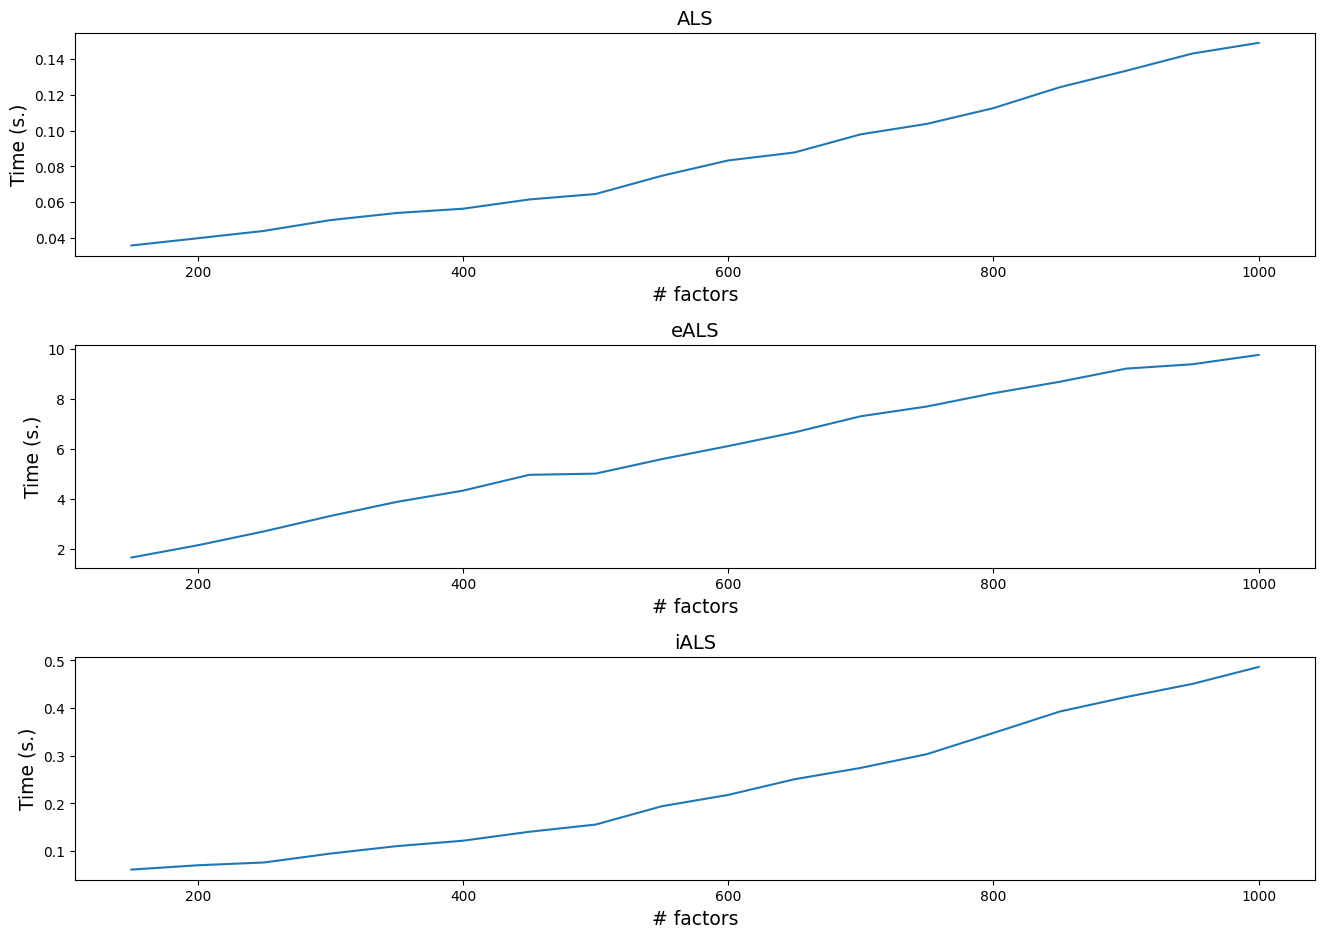

In [17]:
plt.figure(figsize=(16, 11))
plt.subplots_adjust(hspace=0.4)

for i, (name, score) in enumerate(scores.items()):
    plt.subplot(len(scores), 1, i + 1)
    plt.title(name, size=14)
    plt.plot(factors[2:], score[2:])
    plt.xlabel('# factors', size=13.5)
    plt.ylabel('Time (s.)', size=13.5)

plt.show()